because everyone loves Exhaustive(ing) Grid Search!

In [1]:
import numpy as np
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context('talk')
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette("bright", 8))

In [2]:
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score

In [3]:
features, labels = sklearn.datasets.load_breast_cancer(return_X_y=True)

In [4]:
def tune(X, y, param_grid,
         cv=None,
         n_jobs=None):

    pipeline = make_pipeline(
            RobustScaler(),
            RandomForestClassifier(random_state=42)
        )
    
    grid_search = GridSearchCV(pipeline,
                           param_grid,
                           scoring='f1_micro',
                           cv=cv,
                           n_jobs=n_jobs)
    
    grid_search.fit(X, y)
        
    return grid_search.cv_results_, grid_search.best_index_

In [5]:
pipeline = make_pipeline(RobustScaler(),
                          RandomForestClassifier(
                              n_estimators=15,
                              criterion="entropy",
                              max_features="auto",
                              bootstrap=True))
print(pipeline)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', n_estimators=15))])


In [6]:
import time

param_grid = {
  'randomforestclassifier__n_estimators': [1,5,15,50,100]
}

tic = time.perf_counter()
results, best_index = tune(features, labels,
                           param_grid, 
                           cv=StratifiedKFold(n_splits=5))
toc = time.perf_counter()

def print_some_facts(results, best_index, tic, toc):
    print("K Fold Tuning Results")
    print(f"Elapsed Time {toc - tic:0.4f} seconds")
    print("Best Index", best_index)
    print("Best Param Set", results["params"][best_index])
    print(f"F1 Score {results['mean_test_score'][best_index]:.4f} +/- {results['std_test_score'][best_index]}")
    
print_some_facts(results, best_index, tic, toc)

K Fold Tuning Results
Elapsed Time 1.8744 seconds
Best Index 4
Best Param Set {'randomforestclassifier__n_estimators': 100}
F1 Score 0.9561 +/- 0.02283883380490945


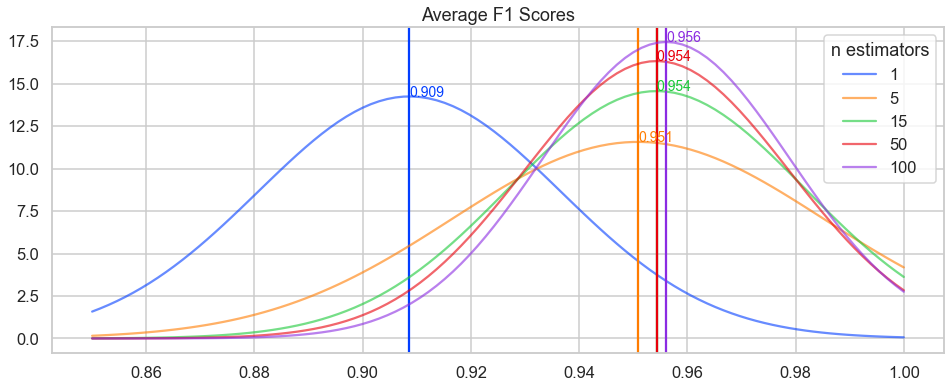

In [7]:
from scipy.stats import norm

def plot_some_results(results):
    fig, ax = plt.subplots(1, 1, figsize=(16,6))
    x = np.linspace(0.85, 1.0, 100)

    mu = results['mean_test_score']
    sigma = results['std_test_score']
    n_estimators = [p["randomforestclassifier__n_estimators"] for p in results["params"]]

    lines = []
    for mu, sigma in zip(results['mean_test_score'], results['std_test_score']):
        pdf = norm.pdf(x, mu, sigma)
        line, = ax.plot(x, pdf, alpha=0.6)
        ax.axvline(mu, color=line.get_color())
        ax.text(mu, pdf.max(), f"{mu:.3f}", color=line.get_color(), fontsize=14)
        lines.append(line)

    plt.legend(handles=lines, labels=n_estimators, title="n estimators")
    ax.set_title(f"Average F1 Scores")
    
plot_some_results(results)

## Increase the size of the search space

In [8]:
#
# 3D search space - 30 combinations - 150 calls to fit
#

param_grid = {
    'randomforestclassifier__n_estimators': [1,5,15,50,100],
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__bootstrap': [True, False]
}

tic = time.perf_counter()
results, best_index = tune(features, labels,
                           param_grid, 
                           cv=StratifiedKFold(n_splits=5))
toc = time.perf_counter()

In [9]:
# Take top N models - TODO buggy??
def take_n_best(x, n):
    idxs = [xx-1 for xx in x["rank_test_score"][:n]]
    y = { k:np.array(v)[idxs] for k,v in x.items() }
    y["rank_test_score"] = list(range(0, len(idxs)))
    return y, 0

K Fold Tuning Results
Elapsed Time 7.8601 seconds
Best Index 0
Best Param Set {'randomforestclassifier__bootstrap': False, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__n_estimators': 100}
F1 Score 0.9701 +/- 0.011885446954182715


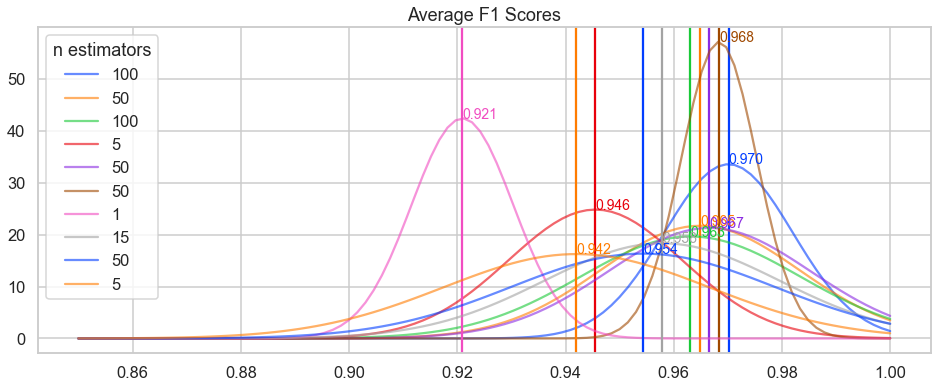

In [10]:
top_results, best_index = take_n_best(results, 10)

print_some_facts(top_results, best_index, tic, toc)

plot_some_results(top_results)

## Really increase the size of the search space

In [ ]:
#
# 6D search space - 960 combinations - 4800 calls to fit
#

param_grid = {
    'randomforestclassifier__n_estimators': [1,5,15,50,100],
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2'],
    'randomforestclassifier__bootstrap': [True, False],
    'randomforestclassifier__min_samples_leaf': [1,2,3,4],
    'randomforestclassifier__min_samples_split': [3,4,5,6] 
}

tic = time.perf_counter()
results, best_index = tune(features, labels,
                           param_grid, 
                           cv=StratifiedKFold(n_splits=5))
toc = time.perf_counter()



In [ ]:
print_some_facts(results, tic, toc)

top_results = take_n_best(results, 10)

plot_the_results(top_results)

## Go Random Go!

In [11]:
from sklearn.model_selection import RandomizedSearchCV

In [12]:
def rand_tune(X, y, param_dist, n_iter=10,
             cv=None,
             n_jobs=None):

    pipeline = make_pipeline(
            RobustScaler(),
            RandomForestClassifier(random_state=42)
        )
    
    grid_search = RandomizedSearchCV(pipeline,
                                   param_dist,
                                   n_iter=n_iter,
                                   scoring='f1_micro',
                                   cv=cv,
                                   n_jobs=n_jobs)
    
    grid_search.fit(X, y)
        
    return grid_search.cv_results_, grid_search.best_index_

In [13]:
import scipy.stats as stats

param_dist = {
    'randomforestclassifier__n_estimators': stats.randint(1,200),
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2'],
    'randomforestclassifier__bootstrap': [True, False],
    'randomforestclassifier__min_samples_leaf': stats.randint(1,5),
    'randomforestclassifier__min_samples_split': stats.randint(3,6) 
}

In [14]:
tic = time.perf_counter()
results, best_index = rand_tune(features,
                                labels,
                                param_dist,
                                n_iter=100,
                                cv=StratifiedKFold(n_splits=5))
toc = time.perf_counter()

K Fold Tuning Results
Elapsed Time 98.3268 seconds
Best Index 0
Best Param Set {'randomforestclassifier__bootstrap': False, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__min_samples_split': 3, 'randomforestclassifier__n_estimators': 77}
F1 Score 0.9684 +/- 0.015278629715567331


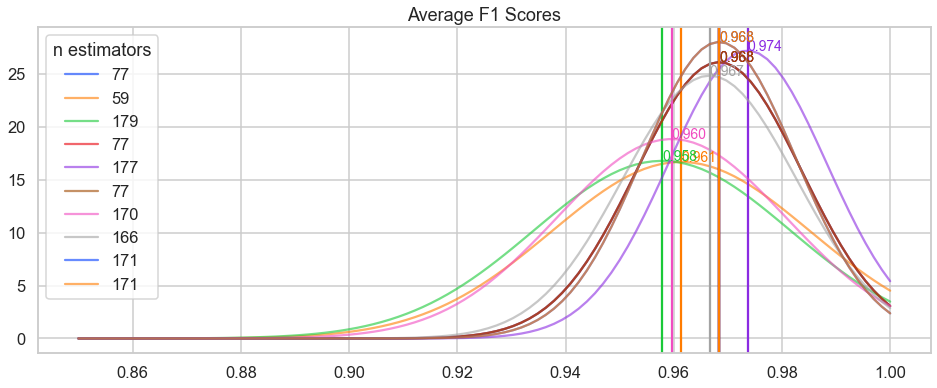

In [15]:
top_results, best_index = take_n_best(results, 10)

print_some_facts(top_results, best_index, tic, toc)
plot_some_results(top_results)

exit

So what have we just done?
 - shown how the performance of a model with a single set of hyperparameters affects our score
 - shown that kfold cv can give us a picture of that distribution which is easier to compute that out-of-bootstrap scores and has less leakage
 - so which model to choose? == in this case which data split, which is not what we want, we want to chose a robust estimator so we want to find a model with the best score distribution for a given set of hyperparameters
 - (note: if we want to do hyperparaemter tuning and want our model selection to be unbiaesed weshould do nested Cross Validaiton, but for simpliciy of the code we are sticking with kfold. See: xxxxx_xxxx_xx.ipynb for the nested cross validaiton example)